In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

# Data 604 - Final Exam Part 1

The first question I chose to solve comes from [chapter 18](https://github.com/AllenDowney/ModSimPy/blob/master/chapters/chap18.ipynb) of "Modelling and Simulation in Python", while has been copied in the cells below. My work begins at cell 21, in the "Exercises" section.

### Code from the previous chapter

Read the data.

In [28]:
data = pd.read_csv('data/glucose_insulin.csv', index_col='time');

Interpolate the insulin data.

In [29]:
I = interpolate(data.insulin)

<function modsim.modsim.interpolate.<locals>.wrapper(x)>

### The glucose minimal model

I'll cheat by starting with parameters that fit the data roughly; then we'll see how to improve them.

In [30]:
params = Params(G0 = 290,
                k1 = 0.03,
                k2 = 0.02,
                k3 = 1e-05)

,values
G0,290.00000
k1,0.03000
k2,0.02000
k3,0.00001


Here's a version of `make_system` that takes the parameters and data:

In [31]:
def make_system(params, data):
    """Makes a System object with the given parameters.
    
    params: sequence of G0, k1, k2, k3
    data: DataFrame with `glucose` and `insulin`
    
    returns: System object
    """
    G0, k1, k2, k3 = params
    
    Gb = data.glucose[0]
    Ib = data.insulin[0]
    I = interpolate(data.insulin)
    
    t_0 = get_first_label(data)
    t_end = get_last_label(data)

    init = State(G=G0, X=0)
    
    return System(params,
                  init=init, Gb=Gb, Ib=Ib, I=I,
                  t_0=t_0, t_end=t_end, dt=2)

In [33]:
system = make_system(params, data)
system.init

,values
G,290.0
X,0.0


And here's the update function.

In [7]:
def update_func(state, t, system):
    """Updates the glucose minimal model.
    
    state: State object
    t: time in min
    system: System object
    
    returns: State object
    """
    G, X = state
    k1, k2, k3 = system.k1, system.k2, system.k3 
    I, Ib, Gb = system.I, system.Ib, system.Gb
    dt = system.dt
        
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X
    
    G += dGdt * dt
    X += dXdt * dt

    return State(G=G, X=X)

Before running the simulation, it is always a good idea to test the update function using the initial conditions.  In this case we can veryify that the results are at least qualitatively correct.

In [8]:
update_func(system.init, system.t_0, system)

,values
G,278.12
X,0.00


Now `run_simulation` is pretty much the same as it always is.

In [9]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    init = system.init
    t_0, t_end, dt = system.t_0, system.t_end, system.dt
    
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    ts = linrange(t_0, t_end, dt)
    
    for t in ts:
        frame.row[t+dt] = update_func(frame.row[t], t, system)
    
    return frame

And here's how we run it.

In [10]:
results = run_simulation(system, update_func);

The results are in a `TimeFrame` object with one column per state variable.

In [11]:
results

,G,X
0,290.000000,0.000000
2,278.120000,0.000000
4,266.952800,0.000300
6,256.295460,0.002668
8,245.070140,0.004041
...,...,...
174,91.044781,-0.000631
176,91.217018,-0.000678
178,91.387668,-0.000725
180,91.556880,-0.000772


The following plot shows the results of the simulation along with the actual glucose data.

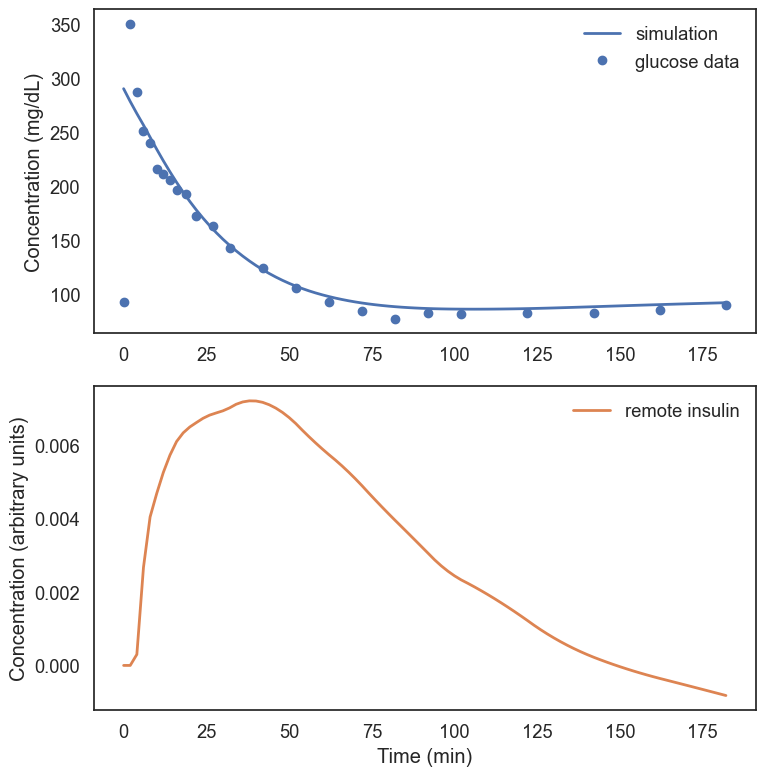

In [12]:
subplot(2, 1, 1)

plot(results.G, 'b-', label='simulation')
plot(data.glucose, 'bo', label='glucose data')
decorate(ylabel='Concentration (mg/dL)')

subplot(2, 1, 2)

plot(results.X, 'C1', label='remote insulin')

decorate(xlabel='Time (min)', 
         ylabel='Concentration (arbitrary units)')

#savefig('figs/chap18-fig01.pdf')

### Numerical solution

Now let's solve the differential equation numerically using `run_ode_solver`, which is an implementation of Ralston's method.

Instead of an update function, we provide a slope function that evaluates the right-hand side of the differential equations.

We don't have to do the update part; the solver does it for us.

In [13]:
def slope_func(state, t, system):
    """Computes derivatives of the glucose minimal model.
    
    state: State object
    t: time in min
    system: System object
    
    returns: derivatives of G and X
    """
    G, X = state
    k1, k2, k3 = system.k1, system.k2, system.k3 
    I, Ib, Gb = system.I, system.Ib, system.Gb
    
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X
    
    return dGdt, dXdt

We can test the slope function with the initial conditions.

In [14]:
slope_func(system.init, 0, system)

(-5.9399999999999995, 0.0)

Here's how we run the ODE solver.

In [15]:
results2, details = run_ode_solver(system, slope_func)

`details` is a `ModSimSeries` object with information about how the solver worked.

In [16]:
details.message

'The solver successfully reached the end of the integration interval.'

`results` is a `TimeFrame` with one row for each time step and one column for each state variable:

In [17]:
results2

,G,X
0,290.000000,0.000000
2,278.476400,0.000150
4,267.464465,0.001478
6,255.898956,0.003303
8,244.423982,0.004284
...,...,...
174,91.149324,-0.000620
176,91.312844,-0.000667
178,91.475442,-0.000714
180,91.637217,-0.000762


Plotting the results from `run_simulation` and `run_ode_solver`, we can see that they are not very different.

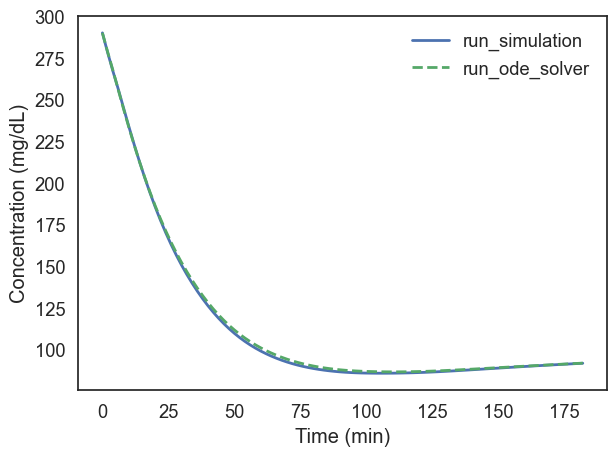

In [18]:
plot(results.G, 'C0', label='run_simulation')
plot(results2.G, 'C2--', label='run_ode_solver')

decorate(xlabel='Time (min)', ylabel='Concentration (mg/dL)')

#savefig('figs/chap18-fig02.pdf')

The differences in `G` are less than 2%.

In [19]:
diff = results.G - results2.G
percent_diff = diff / results2.G * 100
percent_diff

0      0.000000
2     -0.127982
4     -0.191302
6      0.154946
8      0.264360
         ...   
174   -0.114695
176   -0.104943
178   -0.095953
180   -0.087669
182   -0.080037
Name: G, Length: 92, dtype: float64

In [20]:
max(abs(percent_diff))

1.9252541088148694

## Exercises

**Exercise:**  Our solution to the differential equations is only approximate because we used a finite step size, `dt=2` minutes.

If we make the step size smaller, we expect the solution to be more accurate.  Run the simulation with `dt=1` and compare the results.  What is the largest relative error between the two solutions?

---

We can start this problem by creating an updated version of the `make_system` function that grants the ability to easily modify the $dt$ value used when running the simulation:

In [21]:
def make_system(params, data, dt):
    """Makes a System object with the given parameters.
    
    params: sequence of G0, k1, k2, k3
    data: DataFrame with `glucose` and `insulin`
    
    returns: System object
    """
    G0, k1, k2, k3 = params
    
    Gb = data.glucose[0]
    Ib = data.insulin[0]
    I = interpolate(data.insulin)
    
    t_0 = get_first_label(data)
    t_end = get_last_label(data)

    init = State(G=G0, X=0)
    
    return System(params,
                  init=init, Gb=Gb, Ib=Ib, I=I,
                  t_0=t_0, t_end=t_end, dt=dt)    

Using this updated function, we can loop through a list of hypothetical $dt$ values in order to see the impact it has on the approximation of the solution to the differential equation. In this case, `run_simulation` is providing an approximation of $G(t)$, or the glucose level over time. 

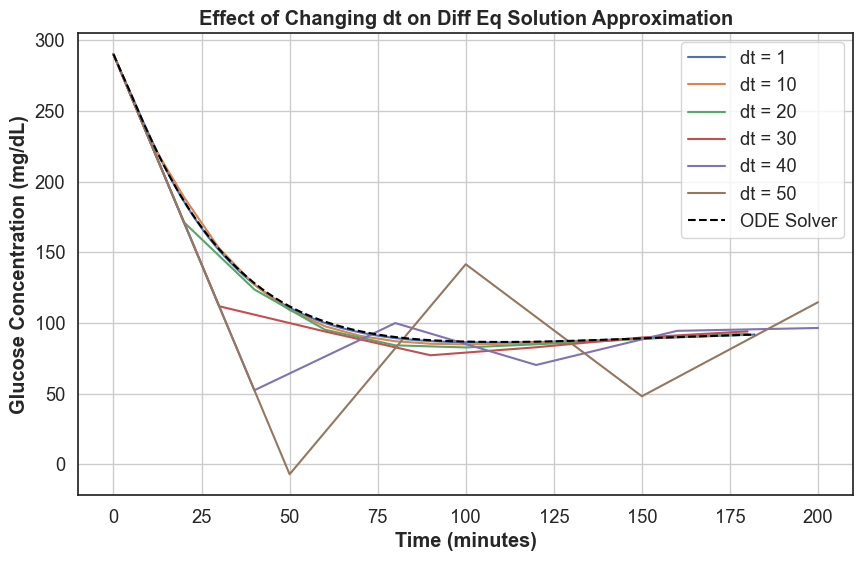

In [22]:
plt.figure(figsize=(10,6))
dts = [1, 10, 20, 30, 40, 50]
for dt in dts:
    system = make_system(params, data, dt)
    results = run_simulation(system, update_func);
    plt.plot(results.index, results.G, label=f'dt = {dt}')

plt.plot(results2.index, results2.G, label='ODE Solver', color='black', ls='--')
plt.title('Effect of Changing dt on Diff Eq Solution Approximation', fontweight='bold')
plt.ylabel('Glucose Concentration (mg/dL)', fontweight='bold')
plt.xlabel('Time (minutes)', fontweight='bold')
plt.legend()
plt.grid()

We can see from the above that the the smaller values of $dt$ most closely align to the results of the ODE solver implemented previously. This is expected, as the approximation should improve as $dt$ shrinks towards 0. We see that for the highest values of $dt$ there are wild flucuations resulting in plots that barely resemble the smooth approximation exhibited when $dt=1$. The cell below attempts to measure this more quantitatively by determining the worst percent differences seen between the approximations and the ODE solver using the different $dt$ values:

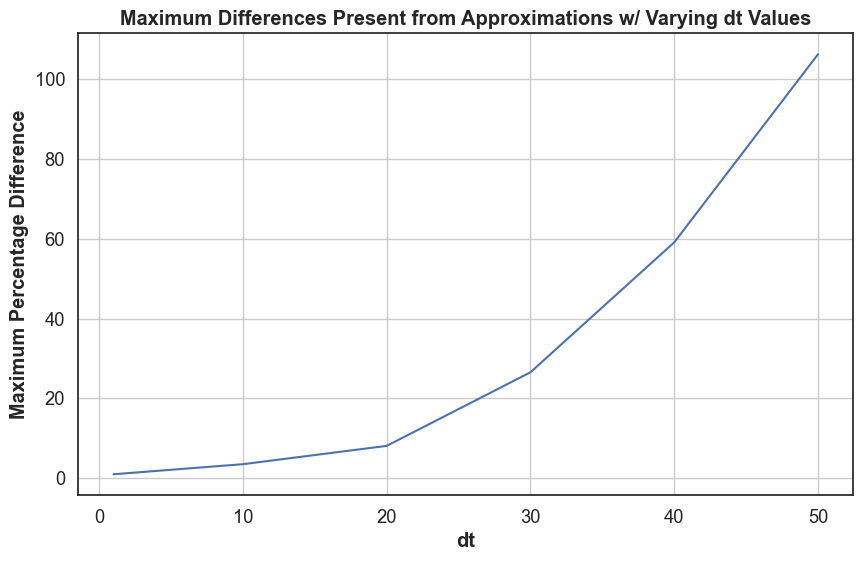

In [23]:
dts = [1, 10, 20, 30, 40, 50]
max_diffs = []
for dt in dts:
    system = make_system(params, data, dt)
    results = run_simulation(system, update_func);
    diffs = results.G - results2.G
    percent_diffs = diffs / results2.G * 100
    max_diffs.append(max(abs(percent_diffs)))

plt.figure(figsize=(10,6))
plt.plot(dts, max_diffs)
plt.title('Maximum Differences Present from Approximations w/ Varying dt Values', fontweight='bold')
plt.ylabel('Maximum Percentage Difference', fontweight='bold')
plt.xlabel('dt', fontweight='bold')
plt.grid()

As expected, we see that the higher values of $dt$ result in the worst percentage differences. The above two plots provide evidence for the fact that when attempting to run simulations, it is advisable to use the lowest value of $dt$ that is computationally feasible. 

## Extra Exercise

This extra exercise is not included in the textbook, but I wanted to use it as practice to get a better handle of using the `run_ode_solver` function on my own.

<b>Question:</b> Solve the ordinary differential equation, $\frac{dx}{dt}=x$ for $x(t)$. 

<b>Solution:</b> This is a good first example to using this function, because the solution is easy to know just by looking at the equation. The only function that equals its derivative is $e^x$. Thus, the results of `run_ode_solver` should produce a plot that aligns with $x(t) = e^x$.


In [24]:
def slope_func(state, t, system):
    X = state
    dXdt = X
    return dXdt

In [25]:
system = System(t_0=0, t_end=5, init=State(X=1.))
results, details = run_ode_solver(system, slope_func)
details.message

'The solver successfully reached the end of the integration interval.'

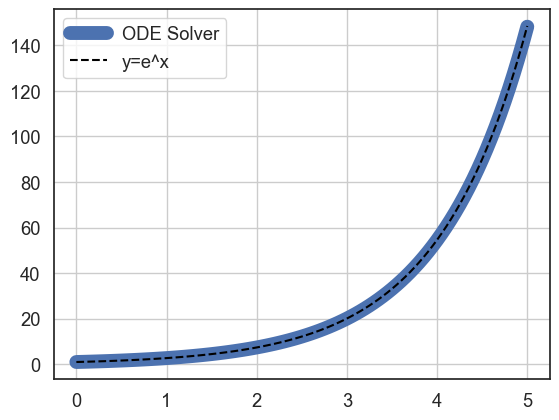

In [26]:
plt.plot(results.index, results.X, label = 'ODE Solver', lw=10)
plt.plot(results.index, np.exp(results.index), label='y=e^x', color='black', ls='--')
plt.grid()
plt.legend()
plt.show()

Thus, we can confirm that the `run_ode_solver` works for this simple example! The above code provides the framework for using this function to solve much more complicated systems of differential equations. 